In [174]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('data/data_all.csv').iloc[:,1:]

In [3]:
data.head()

,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Date,DATE_HOUR,CRASH_DATE,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH
0,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:55:00,CLEAR,DAYLIGHT,DRY,1.0,0.0,15.0,1.0,8.0
1,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:52:00,CLEAR,DAYLIGHT,DRY,2.0,0.0,15.0,1.0,8.0
2,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:45:00,CLEAR,DAYLIGHT,DRY,0.0,0.0,15.0,1.0,8.0
3,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:30:00,CLEAR,DAYLIGHT,DRY,0.0,0.0,15.0,1.0,8.0
4,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:25:00,CLEAR,DAYLIGHT,DRY,3.0,0.0,15.0,1.0,8.0


Aggregation based on each hour

In [126]:
agg = data.groupby('DATE_HOUR').agg({'Temperature': 'mean', 'Dew Point': 'mean', 'Humidity': 'mean', 'Wind Speed': 'mean', 'Pressure': 'mean', 'Date': 'count'}).reset_index()

In [127]:
agg = agg.rename(columns = {'Date': 'Crashes'})

Categorical variables. We cannot use them in groupby since there are categorical, but the one way to keep categorical variable is to save separetely unique values of categorical variables for each unique 'DATE_HOUR' feature. Then we can merge agg data frame with categoracal variables data frame based on 'DATE_HOUR' feature since there are unique in both data frames. 

In [129]:
cat_variab = data.drop_duplicates(subset='DATE_HOUR')[['DATE_HOUR', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK']]

Change format for 'CRASH_HOUR' and 'CRASH_DAY_OF_WEEK' from 'float' to 'category'

In [130]:
cat_variab['CRASH_HOUR'] = cat_variab['CRASH_HOUR'].astype('int').astype('category')
cat_variab['CRASH_DAY_OF_WEEK'] = cat_variab['CRASH_DAY_OF_WEEK'].astype('int').astype('category')

In [131]:
inc_cat_var = pd.merge(agg, cat_variab, on = 'DATE_HOUR')

Plotting

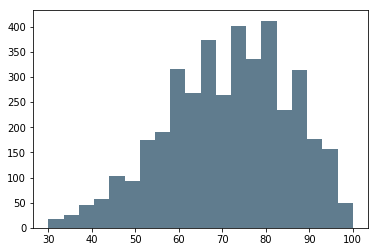

In [132]:
plt.hist(inc_cat_var['Humidity'].values, 20, density=False, align='mid', color='#607c8e');

Humidity feature skewed to the left side. We might be interested in right tail, because high humidity can cause high liklehood of car accident, but we don't interested in left side. So we can delete all rows with himidity less than 40 to make this feature distribution more normal and without loosing any valuable data.

In [133]:
inc_cat_var = inc_cat_var[inc_cat_var['Humidity'] > 40]

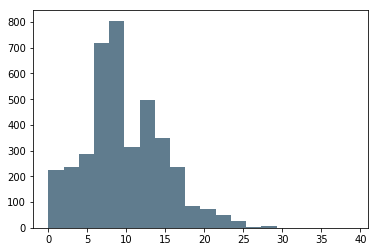

In [134]:
plt.hist(inc_cat_var['Wind Speed'].values, 20, density=False, align='mid', color='#607c8e');

To make wind speed distribution more normal apply np.sqrt

In [135]:
inc_cat_var['Wind Speed'] = inc_cat_var['Wind Speed'].apply(np.sqrt)

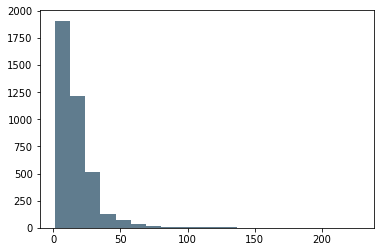

In [136]:
plt.hist(inc_cat_var['Crashes'].values, 20, density=False, align='mid', color='#607c8e');

To make wind target variable distribution more normal apply np.log

In [137]:
y = inc_cat_var.loc[:,['Crashes']].apply(np.log)

There is a multicollinearity in our data between Temperature and Dew Point. So, we are going to use only one feature - Temperature 

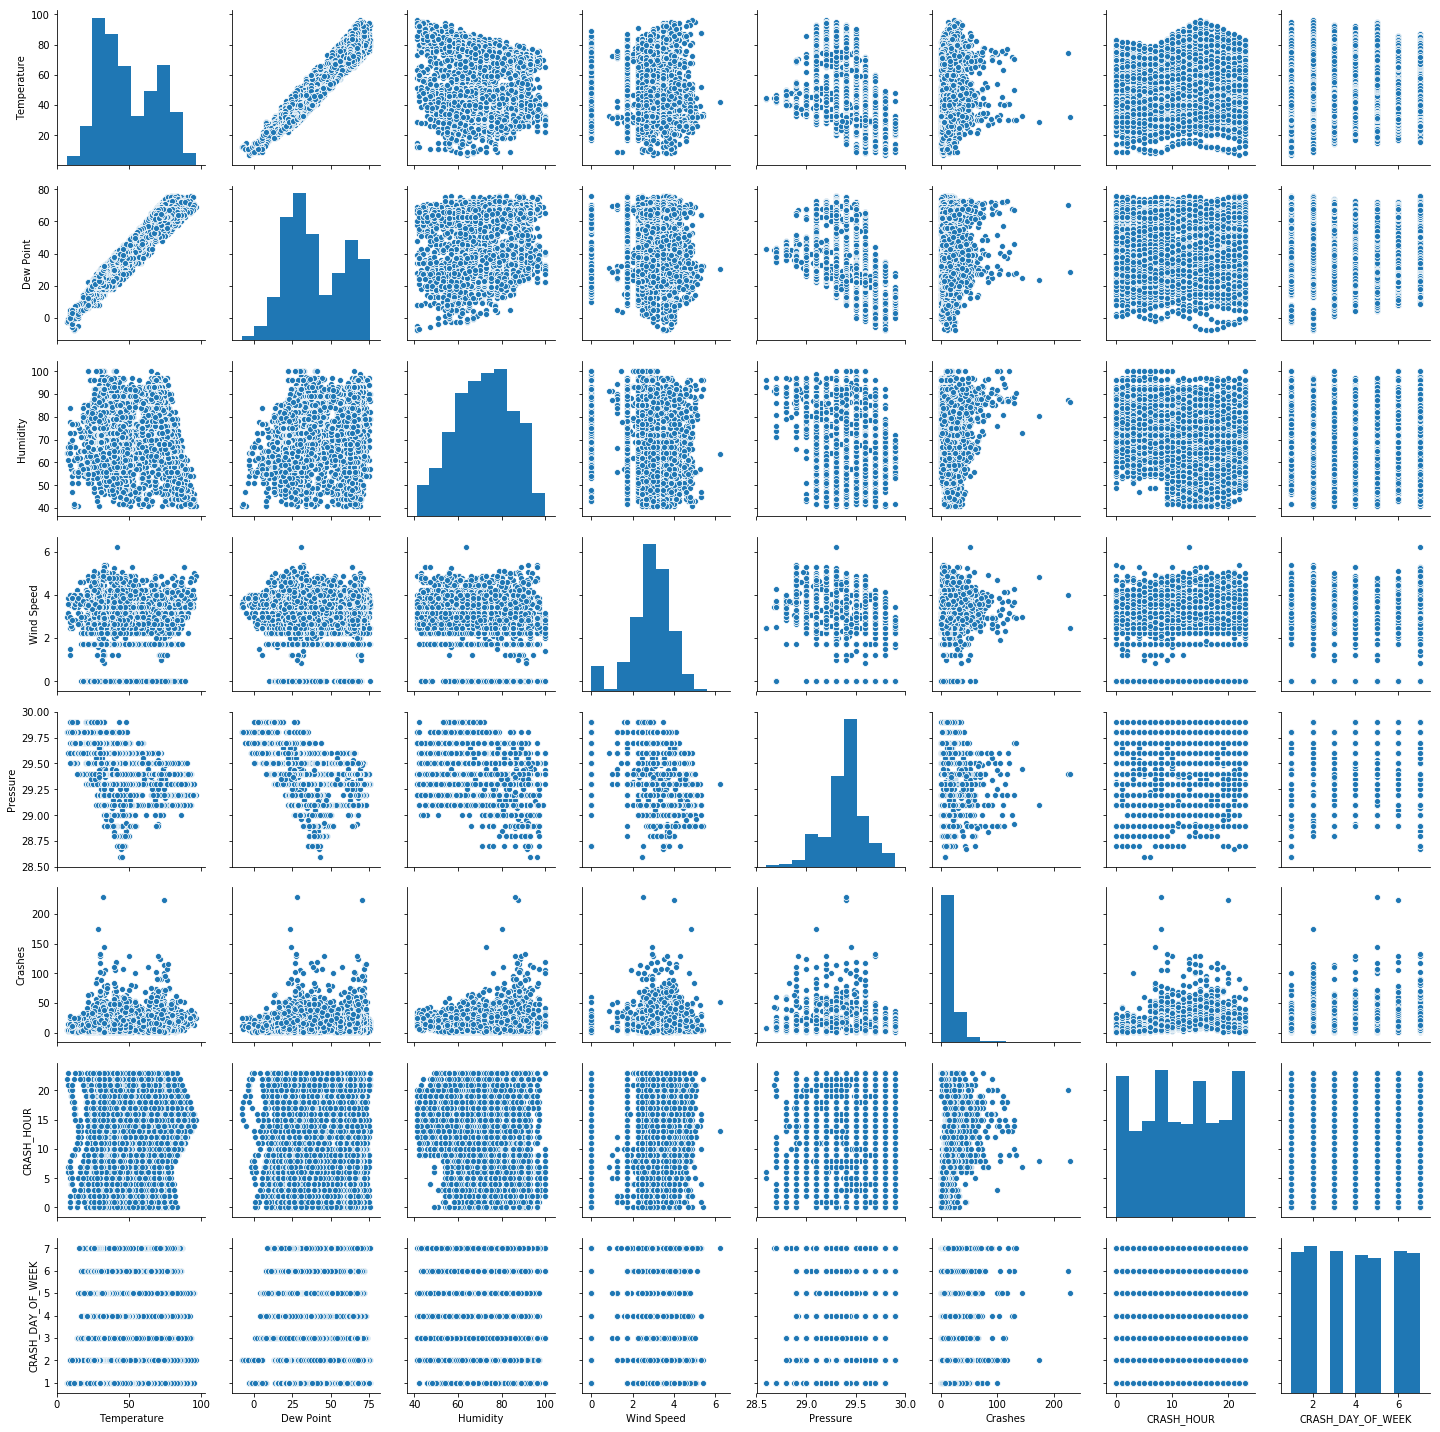

In [138]:
sns.pairplot(inc_cat_var);

In [139]:
inc_cat_var.head()

,DATE_HOUR,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Crashes,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,CRASH_HOUR,CRASH_DAY_OF_WEEK
3,2018-08-05 18,90.0,67.0,46.0,3.741657,29.4,13,CLEAR,DAYLIGHT,DRY,18,1
4,2018-08-05 19,88.0,68.0,51.0,3.000000,29.4,11,CLEAR,DUSK,DRY,19,1
5,2018-08-05 20,87.0,69.0,55.0,3.162278,29.4,7,CLEAR,DARKNESS,DRY,20,1
6,2018-08-05 21,85.0,70.0,61.0,3.162278,29.4,14,CLEAR,"DARKNESS, LIGHTED ROAD",DRY,21,1
7,2018-08-05 22,81.5,69.5,67.5,2.915476,29.4,28,CLEAR,"DARKNESS, LIGHTED ROAD",DRY,22,1


In [140]:
inc_cat_var = inc_cat_var.drop('Dew Point', axis = 1)

In [141]:
inc_cat_var.head()

,DATE_HOUR,Temperature,Humidity,Wind Speed,Pressure,Crashes,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,CRASH_HOUR,CRASH_DAY_OF_WEEK
3,2018-08-05 18,90.0,46.0,3.741657,29.4,13,CLEAR,DAYLIGHT,DRY,18,1
4,2018-08-05 19,88.0,51.0,3.000000,29.4,11,CLEAR,DUSK,DRY,19,1
5,2018-08-05 20,87.0,55.0,3.162278,29.4,7,CLEAR,DARKNESS,DRY,20,1
6,2018-08-05 21,85.0,61.0,3.162278,29.4,14,CLEAR,"DARKNESS, LIGHTED ROAD",DRY,21,1
7,2018-08-05 22,81.5,67.5,2.915476,29.4,28,CLEAR,"DARKNESS, LIGHTED ROAD",DRY,22,1


In [142]:
X = inc_cat_var.drop('Crashes', axis = 1)

Train/test split

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=5, shuffle = False)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [351]:
std = StandardScaler()
std.fit(X_train[num_feat].values)

StandardScaler(copy=True, with_mean=True, with_std=True)

Scaling

In [352]:
cat_feat = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK']
num_feat = ['Temperature', 'Humidity', 'Wind Speed', 'Pressure']

In [353]:
X_train_sc_num = pd.DataFrame(std.transform(X_train[num_feat].values), columns = num_feat)
X_test_sc_num = pd.DataFrame(std.transform(X_test[num_feat].values), columns = num_feat)

In [354]:
X_train_sc_cat = X_train[cat_feat].reset_index(drop = True)
X_test_sc_cat = X_test[cat_feat].reset_index(drop = True)

In [355]:
X_train_sc = pd.concat([X_train_sc_num, X_train_sc_cat], axis=1, join_axes=[X_train_sc_cat.index])
X_test_sc = pd.concat([X_test_sc_num, X_test_sc_cat], axis=1, join_axes=[X_val_sc_cat.index])

In [356]:
X_train_sc = pd.get_dummies(X_train_sc)
X_test_sc = pd.get_dummies(X_test_sc)

In [297]:
X_train_sc.columns;

Feature engineering

In [357]:
X_train_sc['Hum_sq'] = X_train_sc['Humidity']**2
X_test_sc['Hum_sq'] = X_test_sc['Humidity']**2
X_train_sc['Hum**3'] = X_train_sc['Humidity']**3
X_test_sc['Hum**3'] = X_test_sc['Humidity']**3

X_train_sc['CRASH_HOUR_8*WEATHER_CONDITION_RAIN'] = X_train_sc['CRASH_HOUR_8']*X_train_sc['WEATHER_CONDITION_RAIN']
X_test_sc['CRASH_HOUR_8*WEATHER_CONDITION_RAIN'] = X_test_sc['CRASH_HOUR_8']*X_test_sc['WEATHER_CONDITION_RAIN']

In [360]:
model = sm.OLS(np.array(y_train), sm.add_constant(np.array(X_train_sc)))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     85.29
Date:                Tue, 29 Jan 2019   Prob (F-statistic):               0.00
Time:                        19:52:17   Log-Likelihood:                -2756.6
No. Observations:                3136   AIC:                             5621.
Df Residuals:                    3082   BIC:                             5948.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6058      0.061     26.328      0.000       1.486       1.725
x1             0.0084      0.012      0.684      0.494      -0.016       0.032
x2             0.1118      0.024      4.608      0.000       0.064       0.159
x3             0.0255      0.012      2.143      0.032       0.002       0.049
x4             0.0137      0.012      1.102      0.271      -0.011       0.038
x5             0.0991      0.048      2.067      0.039       0.005       0.193
x6             0.1359      0.061      2.227      0.026       0.016       0.256
x7             0.5440      0.157      3.472      0.001       0.237       0.851
x8            -0.1275      0.170     -0.749      0.454      -0.461       0.206
x9             0.3572      0.056      6.363      0.000       0.247       0.467
x10            0.3765      0.081      4.626      0.000       0.217       0.536
x11            0.2205      0.092      2.388      0.017       0.039       0.402
x12            0.2605      0.044      5.941      0.000       0.175       0.347
x13            0.2628      0.034      7.789      0.000       0.197       0.329
x14            0.3722      0.063      5.946      0.000       0.249       0.495
x15            0.3205      0.038      8.418      0.000       0.246       0.395
x16            0.2469      0.055      4.460      0.000       0.138       0.355
x17            0.1429      0.084      1.695      0.090      -0.022       0.308
x18            0.0353      0.089      0.398      0.691      -0.139       0.209
x19            0.0287      0.134      0.214      0.830      -0.234       0.291
x20            0.0078      0.200      0.039      0.969      -0.385       0.400
x21            1.0996      0.517      2.128      0.033       0.086       2.113
x22            0.2500      0.120      2.085      0.037       0.015       0.485
x23           -0.0218      0.105     -0.207      0.836      -0.227       0.184
x24            0.2063      0.091      2.266      0.024       0.028       0.385
x25           -0.8085      0.055    -14.652      0.000      -0.917      -0.700
x26           -0.8851      0.055    -16.114      0.000      -0.993      -0.777
x27           -1.0409      0.057    -18.406      0.000      -1.152      -0.930
x28           -1.0651      0.058    -18.245      0.000      -1.180      -0.951
x29           -1.2340      0.055    -22.246      0.000      -1.343      -1.125
x30           -0.8217      0.053    -15.614      0.000      -0.925      -0.718
x31           -0.3566      0.054     -6.584      0.000      -0.463      -0.250
x32            0.2872      0.056      5.132      0.000       0.177       0.397
x33            0.6004      0.057     10.489      0.000       0.488       0.713
x34            0.4584      0.055      8.347      0.000       0.351       0.566
x35            0.4209      0.056      7.578      0.000       0.312       0.530
x3

In [361]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X_train_sc, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([ 5.69237086e-01, -1.14813926e+19,  5.99192996e-01,  5.86393378e-01,
        1.15741551e-01])

Tuning Regularization Strength via Validation

In [362]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

In [371]:
alphavec = np.linspace(0.0000001,3,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_sc, y_train);

/Users/natali/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/natali/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/natali/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/natali/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py

In [392]:
lasso_model = Lasso(alpha = 0.0000000001)
lasso_model.fit(X_train_sc, y_train);

/Users/natali/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [393]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [394]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_val_sc)

In [395]:
mae(y_test.values, test_set_pred)

0.8987441558970665

MODEL SELECTION

In [396]:
lm = LinearRegression()

In [398]:
lm.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [399]:
test_set_pred = lm.predict(X_val_sc)

In [400]:
mae(y_test.values, test_set_pred)

52468102220.49386